In [14]:
%matplotlib inline
import os, pickle, logging, pickle, joblib, sys, warnings
warnings.simplefilter('ignore')
from scipy import stats
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

from sklearn import ensemble, metrics, pipeline, preprocessing, impute, model_selection
from scipy.stats import pearsonr, spearmanr

import shap

font_path = "/home/zhoujb/local/font/Times New Roman.ttf"
mpl.font_manager.fontManager.addfont(font_path)
prop = mpl.font_manager.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

RAW_PATH = "/data2/zhoujb/project/cowpea_project/rawData/"
ML_RAW_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/rawData/"
FS_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/fs_PSugar/"
TEST_RES_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/tesRes/"
FIG_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/figRes/"

def letter_annotation(ax, xoffset, yoffset, letter):

    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
    ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
            size=20, weight='bold')

In [15]:
feat_col_raw = []
with open(os.path.join(FS_PATH, "cb_rfa_cv_psugar_rmse")) as f:
    for line in f:
        feat_col_raw.append(line.strip())

feat_col = []
feat_col_map = {}
for item in feat_col_raw:
    feat_col.append(item[4:])
    feat_col_map[item] = item[4:]


raw_data = pd.read_table(os.path.join(ML_RAW_PATH, "raw_data_PSugar.txt"), sep="\t", index_col=0)
raw_data = raw_data.rename(columns=feat_col_map)

target_col = ['GZ-PSugar']
raw_data = raw_data.dropna(subset=target_col)

kf = model_selection.KFold(n_splits=5, shuffle=True,  random_state=0)
y_test_final, y_pred_final = [], []
for i, (train_index, test_index) in enumerate(kf.split(raw_data)):
    data_train = raw_data.iloc[train_index].copy()
    data_test = raw_data.iloc[test_index].copy()

    scale_tool = preprocessing.StandardScaler()
    scale_tool.fit(data_train.loc[:, feat_col])
    data_train.loc[:, feat_col] = scale_tool.transform(data_train.loc[:, feat_col])
    data_test.loc[:, feat_col] = scale_tool.transform(data_test.loc[:, feat_col])

    train_sel = data_train.sample(frac=0.8, random_state=0)
    val_sel = data_train.drop(train_sel.index).copy()

    X_train = train_sel[feat_col].copy()
    y_train = train_sel[target_col].values.ravel()

    X_val = val_sel[feat_col].copy()
    y_val = val_sel[target_col].values.ravel()

    X_test = data_test[feat_col].copy()
    y_test = data_test[target_col].values.ravel()

    if i == 4:
        break

# Initialize CatBoostClassifier
clf_model = cb.CatBoostRegressor(random_state=0, thread_count=4, loss_function='RMSE')
# Fit model
clf_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, plot=False)

y_pred = clf_model.predict(X_test)

#score_pear = pearsonr(y_test, y_pred)[0]
score_spear = spearmanr(y_test, y_pred)[0]
score_rmse = metrics.root_mean_squared_error(y_test, y_pred)
score_nrmse = score_rmse / np.std(y_test)

score_spear, score_rmse, score_nrmse

(0.8095744874060047, 1.8237944197053078, 0.631624008936715)

In [16]:
data_scale = raw_data[feat_col].copy()
data_scale.loc[:, feat_col] = scale_tool.transform(data_scale.loc[:, feat_col])

explainer = shap.TreeExplainer(clf_model)
shap_values = explainer(data_scale[feat_col])

In [17]:
shap_val_df = pd.DataFrame(shap_values.values, columns=feat_col)
shap_feat_import = shap_val_df.abs().mean(0).sort_values(ascending=False).to_frame()
shap_feat_import.shape

(47, 1)

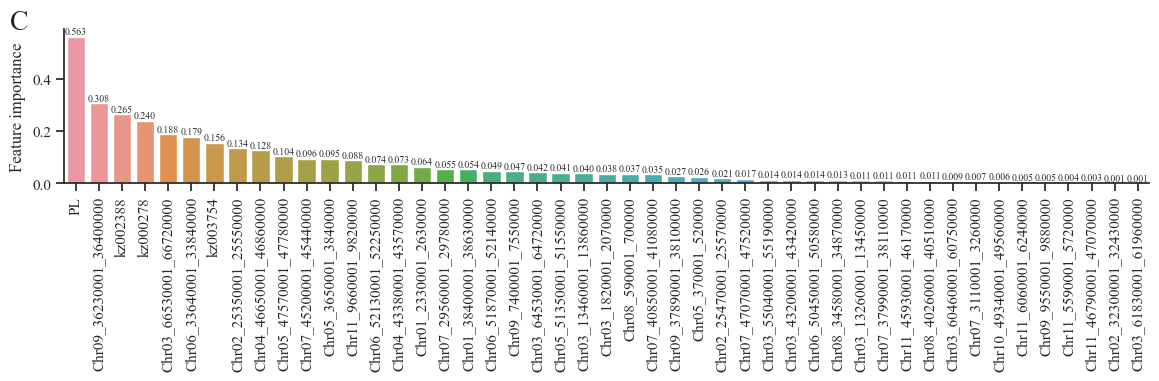

In [23]:
shap_val_df = pd.DataFrame(shap_values.values, columns=feat_col)
shap_feat_import = shap_val_df.abs().mean(0).sort_values(ascending=False).to_frame()
shap_feat_import = shap_feat_import.rename(columns={0:"SHAP value"})
shap_feat_import.index.name = "Feature"
shap_feat_import = shap_feat_import.reset_index()
shap_feat_import

sns.set(style="ticks", font_scale=1, rc={'figure.figsize':(14, 2)})

mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]

ax = sns.barplot(data=shap_feat_import, x="Feature", y="SHAP value")
ax.bar_label(ax.containers[0],  fmt='%.3f', fontsize=7)
#ax.set_yscale('log')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.set(xlabel="", ylabel="Feature importance")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

letter_annotation(ax, -0.05, 1, "C")

plt.savefig(os.path.join(FIG_PATH, "fig_5_C_PSugar_all_feat_shap_value.pdf"), format="pdf", bbox_inches="tight", transparent=True)

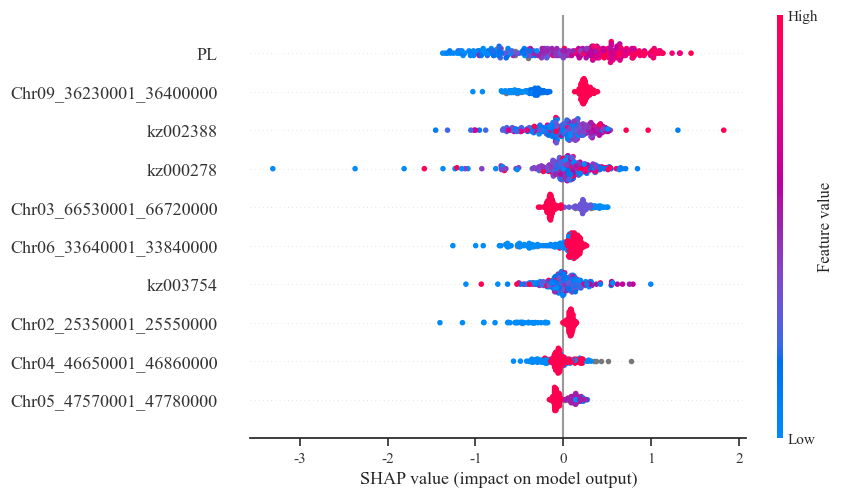

In [19]:
top_feat_list = shap_feat_import["Feature"].to_list()[:10]

with plt.rc_context():
    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
    mpl.rcParams['axes.unicode_minus'] = False
    
    shap.plots.beeswarm(shap_values[:,top_feat_list], max_display=10, show=False)
    plt.savefig(os.path.join(FIG_PATH, "fig_5_D_PSugar_global_beeswarm_plot.pdf"), format="pdf", dpi=1000, bbox_inches="tight", transparent=True)

In [ ]:
kz002388 LysoPE 15:1 溶血磷脂酰乙醇胺 15:1 LPE
kz000278 Indole 3-acetic acid (IAA) 吲哚-3-乙酸 Alkaloids
kz003754 Isoscutellarein 异高山黄芩素 Flavones

In [20]:
raw_data_sel = raw_data[feat_col].copy()
detail_info = pd.read_excel(os.path.join(RAW_PATH, "Detail_information_344.xlsx"), index_col="Genotype No.")
detail_info = detail_info.loc[raw_data_sel.index]
detail_info["Type"] = detail_info["Types"].map({'Grain':"G", 'V-landrace':"VL", '-':"NA", 'V-cultivar':"VC"})

#Source = detail_info.loc[data_scale.index]["Type"].to_list()

target_df = raw_data[target_col]
target_df = pd.concat([target_df, detail_info[["Type"]]], axis=1)

#detail_info = detail_info.reset_index()
#g_num = detail_info[detail_info["Type"]=="G"].index.to_list()
#vl_num = detail_info[detail_info["Type"]=="VL"].index.to_list()
#na_num = detail_info[detail_info["Type"]=="NA"].index.to_list()
#vc_num = detail_info[detail_info["Type"]=="VC"].index.to_list()

data_sel_info = pd.concat([raw_data_sel, detail_info[["Type"]]], axis=1, sort=False)
data_sel_info = data_sel_info.loc[raw_data_sel.index]
data_sel_info = data_sel_info.reset_index()

data_shap_val = shap_val_df.copy()
data_shap_val = data_shap_val.rename(columns={x:"{}_shap".format(x) for x in shap_val_df.columns})

data_for_plot = pd.concat([data_sel_info, data_shap_val], axis=1, sort=False)
data_for_plot["Type"] = data_for_plot["Type"].astype("category")
data_for_plot["Type"] = data_for_plot["Type"].cat.set_categories(["VC", "VL", "G", "NA"])

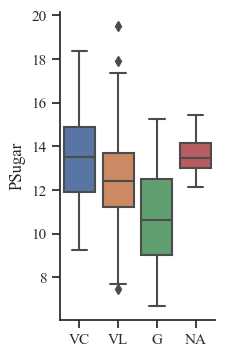

In [9]:
with plt.rc_context():
    sns.set(style="ticks", font_scale=1, rc={'figure.figsize':(2, 4)})

    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
    mpl.rcParams['axes.unicode_minus'] = False
    
    box_ax = sns.boxplot(data=target_df, x="Type", y="HZ-PSugar", showfliers = True,
                         order=["VC", "VL", "G", "NA"], boxprops={'alpha': 1})
    
    box_ax.set(xlabel="", ylabel="PSugar")
    box_ax.spines.right.set_visible(False)
    box_ax.spines.top.set_visible(False)

    plt.savefig(os.path.join(FIG_PATH, "fig_6_PSugar_pheno_value.pdf"), format="pdf", bbox_inches="tight", transparent=True)

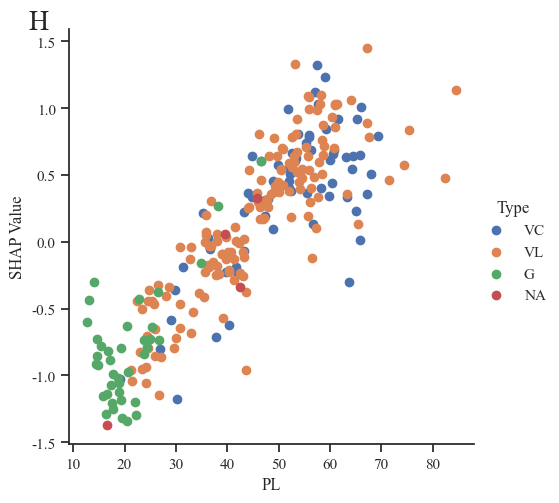

In [22]:
feat_name = shap_feat_import["Feature"].to_list()[0]
#sns.set(style="ticks", font_scale=1, rc={'figure.figsize':(6, 6)})

mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False

ax = sns.lmplot(data=data_for_plot, x=feat_name, 
                y="{}_shap".format(feat_name), 
                hue="Type", fit_reg=False, x_jitter=0.02, scatter_kws={'alpha': 1})
ax.set(ylabel="SHAP Value")

letter_annotation(ax.axes.flat[0], -0.1, 1, "H")

plt.savefig(os.path.join(FIG_PATH, "fig_5_H_PSugar_{}_value.pdf".format(feat_name)), format="pdf", bbox_inches="tight", transparent=True)

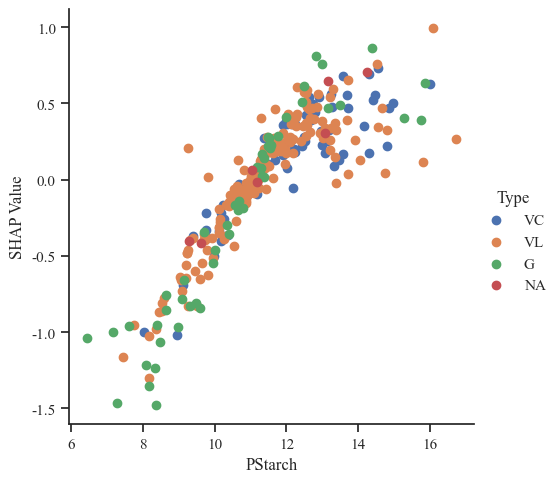

In [11]:
feat_name = shap_feat_import["Feature"].to_list()[1]
#sns.set(style="ticks", font_scale=1, rc={'figure.figsize':(6, 6)})

mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False

ax = sns.lmplot(data=data_for_plot, x=feat_name, 
                y="{}_shap".format(feat_name), 
                hue="Type", fit_reg=False, x_jitter=0.02, scatter_kws={'alpha': 1})
ax.set(ylabel="SHAP Value")

plt.savefig(os.path.join(FIG_PATH, "fig_6_PSugar_{}_value.pdf".format(feat_name)), format="pdf", bbox_inches="tight", transparent=True)

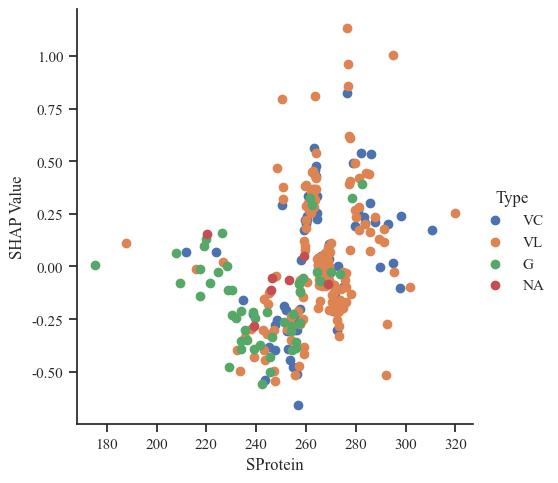

In [12]:
feat_name = shap_feat_import["Feature"].to_list()[2]
#sns.set(style="ticks", font_scale=1, rc={'figure.figsize':(6, 6)})

mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False

ax = sns.lmplot(data=data_for_plot, x=feat_name, 
                y="{}_shap".format(feat_name), 
                hue="Type", fit_reg=False, x_jitter=0.02, scatter_kws={'alpha': 1})
ax.set(ylabel="SHAP Value")

plt.savefig(os.path.join(FIG_PATH, "fig_6_PSugar_{}_value.pdf".format(feat_name)), format="pdf", bbox_inches="tight", transparent=True)

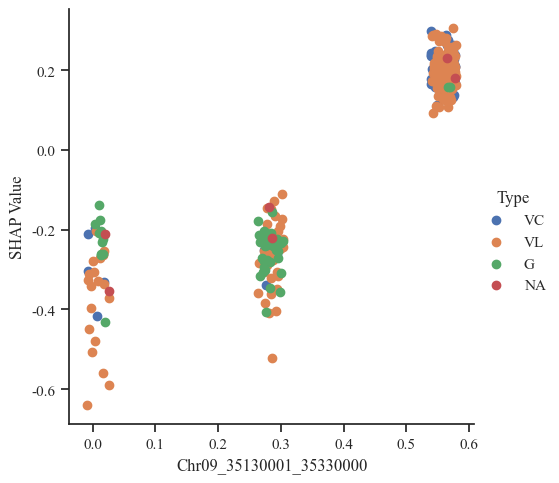

In [13]:
feat_name = shap_feat_import["Feature"].to_list()[3]
#sns.set(style="ticks", font_scale=1, rc={'figure.figsize':(6, 6)})

mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False

ax = sns.lmplot(data=data_for_plot, x=feat_name, 
                y="{}_shap".format(feat_name), 
                hue="Type", fit_reg=False, x_jitter=0.02, scatter_kws={'alpha': 1})
ax.set(ylabel="SHAP Value")

plt.savefig(os.path.join(FIG_PATH, "fig_6_PSugar_{}_value.pdf".format(feat_name)), format="pdf", bbox_inches="tight", transparent=True)

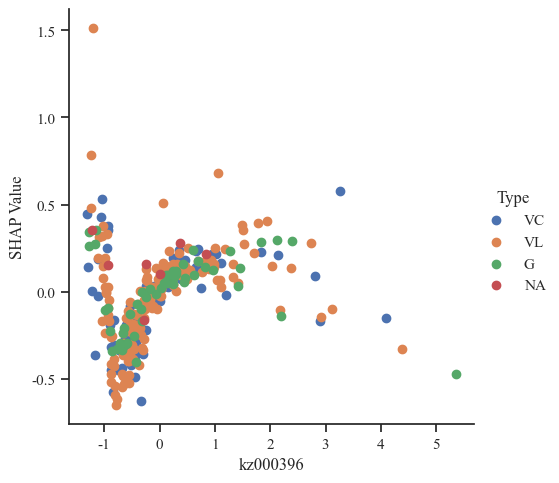

In [14]:
feat_name = shap_feat_import["Feature"].to_list()[4]
#sns.set(style="ticks", font_scale=1, rc={'figure.figsize':(6, 6)})

mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False

ax = sns.lmplot(data=data_for_plot, x=feat_name, 
                y="{}_shap".format(feat_name), 
                hue="Type", fit_reg=False, x_jitter=0.02, scatter_kws={'alpha': 1})
ax.set(ylabel="SHAP Value")

plt.savefig(os.path.join(FIG_PATH, "fig_6_PSugar_{}_value.pdf".format(feat_name)), format="pdf", bbox_inches="tight", transparent=True)

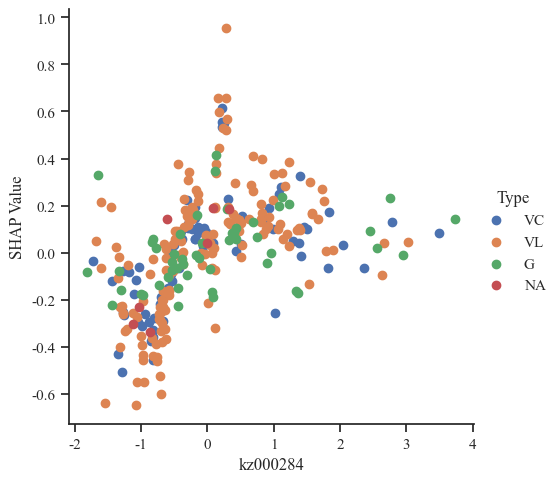

In [15]:
feat_name = shap_feat_import["Feature"].to_list()[5]
#sns.set(style="ticks", font_scale=1, rc={'figure.figsize':(6, 6)})

mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False

ax = sns.lmplot(data=data_for_plot, x=feat_name, 
                y="{}_shap".format(feat_name), 
                hue="Type", fit_reg=False, x_jitter=0.02, scatter_kws={'alpha': 1})
ax.set(ylabel="SHAP Value")

plt.savefig(os.path.join(FIG_PATH, "fig_6_PSugar_{}_value.pdf".format(feat_name)), format="pdf", bbox_inches="tight", transparent=True)